## Digester
Un digester est une usine qui produit du papier ou carton à partir du bois.

### Description des données
Nom du fichier: `digester_data.csv`

Il y a environ un mois de données dans ce fichier (5968 lignes). 
Les données sont enregistrées toutes les 10 minutes.

Il y a 37 colonnes dans ce dataset. Ce sont toutes des mesures provenant de capteurs dans l'usine.  
La plus improtante est `Blow Kappa` qui mesure la qualité de la production.  
**L'objectif est de prédire ce `Blow Kappa` en utilisant les autres capteurs.**

In [239]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tensorflow import keras
from keras import layers


## Constantes

In [240]:
WINDOW_SIZE = 10
TEST_PORTION = 0.3
MAX_DATE = "16.12.2018 05:30:00"
DELTA_TIME = (WINDOW_SIZE - 1) * 10
Y_COLUMNS = ['Blow Kappa', 'Digester Production'] # 'Digester Chip Level Bottom Sensor', 'Digester Chip Level Middle Sensor'

In [241]:
# Loading dataset
import time
import datetime

data = pd.read_csv('digester_data.csv', index_col=0, parse_dates=True)
data = data.dropna()

data = data[:MAX_DATE]

max_time = time.mktime(time.strptime(MAX_DATE, '%d.%m.%Y %H:%M:%S'))
min_time = time.mktime(time.strptime(str(data.index[0]), '%Y-%m-%d %H:%M:%S'))

split_time = (max_time - min_time) * (1 - TEST_PORTION) + min_time
split_date = datetime.datetime.fromtimestamp(split_time)

train_data = data[:split_date]
test_data = data[split_date:]

Y_COLUMNS_INDEXES = [data.columns.get_loc(col) for col in Y_COLUMNS]

data.head()

,Wash Filtrate to Digester - Total Flow,Wash Filtrate Vertical Nozzle,White Liquor Flow to ITC,H-factor,H-factor Co-Current,H-factor Target,H-factor Counter-Current,Volumetric Chip Flow,Chip Mass Flow from Piles,Spruce Saw Mill Chips Share,...,Hot Spent Digester Liquor Specific Flow to Impregnation Vessel,Digester Production,Digester Long Level,Digester Chip Level Control,Digester Dilution Factor,Digester Short Level,Blow Kappa,Blow Temperature,Blow Production,Weak Black Liquor to Evaporation Plant Residual Alkali
Time,,,,,,,,,,,,,,,,,,,,,
2018-11-17 05:30:00,110.2245,99.17144,0.666082,654.5113,343.3514,640.0,311.1599,562.5585,28.57158,0.0,...,2.700000,900.7260,88.44555,18.03286,2.087241,48.00631,27.06810,81.31033,944.3789,9.08
2018-11-17 05:40:00,110.1122,98.94392,0.664136,661.8202,346.3676,640.0,315.4526,633.1141,32.40237,0.0,...,2.700000,901.0746,88.48584,16.11140,2.120218,48.22581,26.91316,81.29632,935.1744,9.08
2018-11-17 05:50:00,110.5644,99.35569,0.663386,641.0970,347.7459,640.0,293.3511,639.0107,32.13532,0.0,...,2.700000,901.1793,88.58454,19.01828,2.094056,48.28634,26.75613,81.33907,943.5457,9.08
2018-11-17 06:00:00,111.6846,100.51020,0.667563,636.6735,340.1161,640.0,296.5574,566.5072,28.39081,0.0,...,2.699660,901.0532,88.60841,19.94156,2.074880,48.21948,26.29543,81.32839,942.8271,9.08
2018-11-17 06:10:00,113.5258,101.86900,0.683108,648.1323,344.1459,640.0,303.9865,476.2530,24.19455,0.0,...,2.675004,930.5841,88.82150,16.25405,2.121525,48.34011,25.98184,81.47342,959.3496,9.08


In [242]:
def plot_data(y_train, y_test):
    nb_features = y_train.shape[1]

    fig, ax  = plt.subplots(nb_features, 1, figsize=(20, nb_features * 5))
    fig.suptitle("Dataset")

    for i in range(nb_features):
        a = ax

        if nb_features > 1:
            a = ax[i]

        a.plot(y_train[:, i])
        padding = np.array([None] * y_train.shape[0])
        a.plot(np.concatenate((padding, y_test[:, i])))
        
        a.set_title(Y_COLUMNS[i])
        
    plt.show()

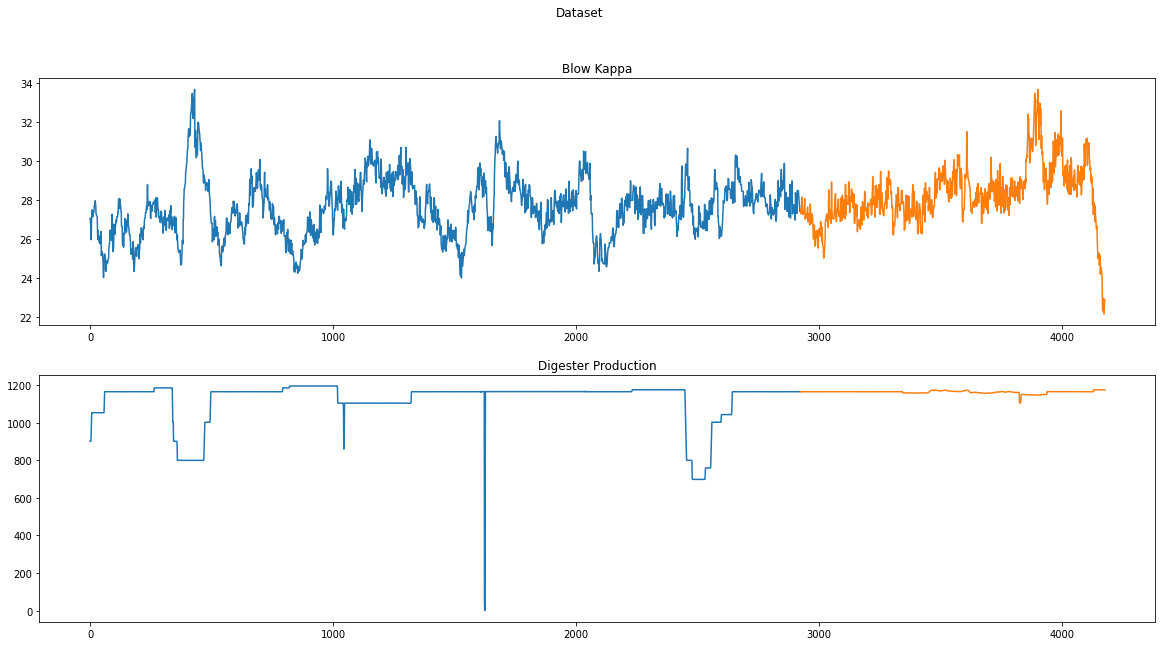

In [243]:
plot_data(train_data.to_numpy()[:, Y_COLUMNS_INDEXES], 
          test_data.to_numpy()[:, Y_COLUMNS_INDEXES])

# Create window

In [244]:
def to_window(df):
    X = []
    y = []

    for row in df.iterrows():
        wind_start = row[0]
        wind_stop = wind_start + pd.Timedelta(minutes=DELTA_TIME)
        window = df[wind_start:wind_stop].to_numpy()
        
        if len(window) == WINDOW_SIZE:
            X.append(window[0:WINDOW_SIZE-1])
            y.append(window[WINDOW_SIZE-1][Y_COLUMNS_INDEXES])
            
    X = np.array(X)
    y = np.array(y)
    return (X, y)

In [245]:
X_train, y_train = to_window(train_data)
X_test, y_test = to_window(test_data)

print(X_train.shape)
print(y_train.shape)

(2915, 9, 37)
(2915, 2)


# Create and train CNN

In [246]:

model = keras.Sequential(
    [
        layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
        layers.Conv1D(
            filters=512, kernel_size=2, padding="same", activation="relu"
        ),
        layers.Flatten(),
        layers.Dense(2, activation='relu')
    ]
)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mse")
model.summary()


Model: "sequential_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_29 (Conv1D)          (None, 9, 512)            38400     
                                                                 
 flatten_23 (Flatten)        (None, 4608)              0         
                                                                 
 dense_23 (Dense)            (None, 2)                 9218      
                                                                 
Total params: 47,618
Trainable params: 47,618
Non-trainable params: 0
_________________________________________________________________


In [247]:
history = model.fit(
    X_train,
    y_train,
    epochs=100,
    batch_size=128,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, mode="min")
    ],
)


Epoch 1/100
21/21 [==============================] - 1s 16ms/step - loss: 70484.0938 - val_loss: 2180.2046
Epoch 2/100
21/21 [==============================] - 0s 10ms/step - loss: 5431.6250 - val_loss: 517.5447
Epoch 3/100
21/21 [==============================] - 0s 8ms/step - loss: 2097.2490 - val_loss: 506.4632
Epoch 4/100
21/21 [==============================] - 0s 9ms/step - loss: 1623.2825 - val_loss: 775.0640
Epoch 5/100
21/21 [==============================] - 0s 7ms/step - loss: 1496.3115 - val_loss: 687.4054
Epoch 6/100
21/21 [==============================] - 0s 7ms/step - loss: 1387.9021 - val_loss: 596.3344
Epoch 7/100
21/21 [==============================] - 0s 8ms/step - loss: 1308.6133 - val_loss: 625.2532
Epoch 8/100
21/21 [==============================] - 0s 8ms/step - loss: 1245.2509 - val_loss: 541.3893
Epoch 9/100
21/21 [==============================] - 0s 7ms/step - loss: 1187.3541 - val_loss: 569.8703
Epoch 10/100
21/21 [==============================] - 0s 7ms

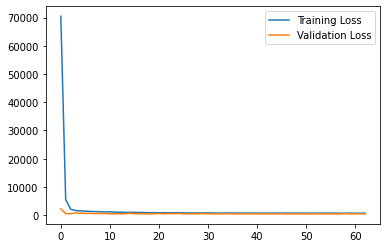

In [248]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()
plt.show()


# Baseline

In [249]:
def baseline(X):
    y = []

    for t in X:
        y.append(np.average(t[:, Y_COLUMNS_INDEXES], axis=0))

    return np.array(y)

# Plot tests

In [250]:
def scatter_plot(y_true, y_pred, name):
    nb_features = y_true.shape[1]


    fig, ax = plt.subplots(nb_features, 1, figsize=(20, nb_features * 5))
    fig.suptitle(name)

    for i in range(nb_features):
        a = ax

        if nb_features > 1:
            a = ax[i]

        lim_max = max(np.concatenate([y_true[:, i], y_pred[:, i]]))
        lim_min = min(np.concatenate([y_true[:, i], y_pred[:, i]]))

        a.scatter(y_true[:, i], y_pred[:, i])

        a.set_title(Y_COLUMNS[i])
        a.set_xlabel('Actual')
        a.set_ylabel('Pred')

        a.set_xlim((lim_min, lim_max))
        a.set_ylim((lim_min, lim_max))

    plt.show()

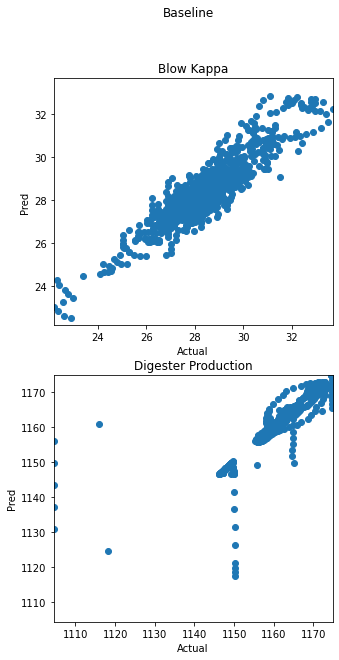

Baseline mea 0.7084850727938544
Baseline mse 7.202990920377884


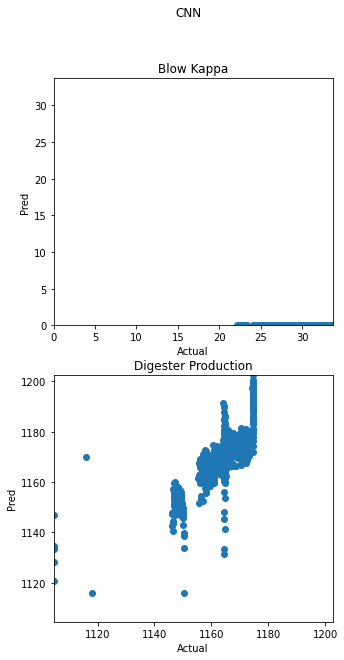

CNN mea 17.366110212143273
CNN mse 435.38489610252714


In [251]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

y_baseline = baseline(X_test)
y_predCNN = model.predict(X_test)

scatter_plot(y_test, y_baseline, "Baseline")
print(f"Baseline mea {mean_absolute_error(y_test, y_baseline)}")
print(f"Baseline mse {mean_squared_error(y_test, y_baseline)}")

scatter_plot(y_test, y_predCNN, "CNN")
print(f"CNN mea {mean_absolute_error(y_test, y_predCNN)}")
print(f"CNN mse {mean_squared_error(y_test, y_predCNN)}")